# Objective
- Demonstrate the effect of downsampling and matched cohorts have on outcomes

In [2]:
from pathlib import Path
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import importlib
import mlflow as ml

import utillities as ut
import surv_bart as bmb

There are two connected py files for this workflow. 
- Utilities provides the simulation generator fx and additional evaluation metrics
- surv_bart (bmb) is the bart model wrapper. With an sklearn like api it conveniently extends the bart model for sv settings

In [71]:
importlib.reload(ut)
importlib.reload(bmb)

<module 'cc_6_bart_model_builder' from '/home/twj8/pymc_bart/eval_5_cc/cc_6_bart_model_builder.py'>

# Create a simulation dataset

In [72]:
# generage the random number generator object
rng = np.random.default_rng(seed=990)

Simulation is based on a weibull model with a lambda and alpha parameters. It generates true survival/hazard fxs as well as random event/status times from the inverse of the weibull pdf. 

The covariate matrix is generated from as number of observations (N), number of variables (x_vars) and class of variables beings binary or continuous. Probability of draws for the var_class ==2 (binary) is given by the corresponding index of the var_prob. 

Lambda and alpha are calculated from the linear equation defined around the x_mat covariate matrix. 

eos and time_scale represent an end of study marker and a event time scaling to reduce time points.

Returns:
- t_event is event time
- status is 1 if event occurs or 0 if censored
- x_mat is the covariate matrix
- true is the true sv/hz at times
- true_scale is the true sv/hz at times scaled to the t_event scale

In [73]:
N = 10000
X_VARS = 10
VAR_CLASS = [2,10,3,1,2]
VAR_PROB = [0.5, 0.5, 0.5, 0.5, 0.5]
LAMBDA = "np.exp(-5 + .2*x_mat[:,0] + 0.01*np.log(x_mat[:,1]+0.00001) + 0.2*(x_mat[:,2] + x_mat[:,3] + x_mat[:,4]))" 
ALPHA_F = "3 + .1*x_mat[:,0]"
eos = 120
time_scale=20


# get SV
x_mat = ut.get_x_matrix(N=N, x_vars=X_VARS, VAR_CLASS=VAR_CLASS, VAR_PROB=VAR_PROB, rng=rng)
t_event, status, x_mat, true, true_scale = ut.sim_surv(x_mat, LAMBDA, ALPHA_F, eos, time_scale=time_scale, return_full=True, rng = rng)

A test dataset can be created using the simulation fxs with the same parameters as the train dataset. The rng object instantiated above allows for reproducible sampling with a set seed.

In [74]:
# test
t_x_mat = ut.get_x_matrix(N=N, x_vars=X_VARS, VAR_CLASS=VAR_CLASS, VAR_PROB=VAR_PROB, rng=rng)
t_t_event, t_status, t_x_mat, t_true, t_true_scale = ut.sim_surv(t_x_mat, LAMBDA, ALPHA_F, eos, time_scale=time_scale, return_full=True, rng=rng)

To check the the simulated datasets are appropriate comparison of the simulated KPM output scaled and uncaled to the true sv times is completed below. 

With a high number of observations it is apparent that the simulated datasets KPM stratified on the first covariate (which has been named "covid") for correspondence with the actual proposed analyses appropriately approximates the true sv curves.

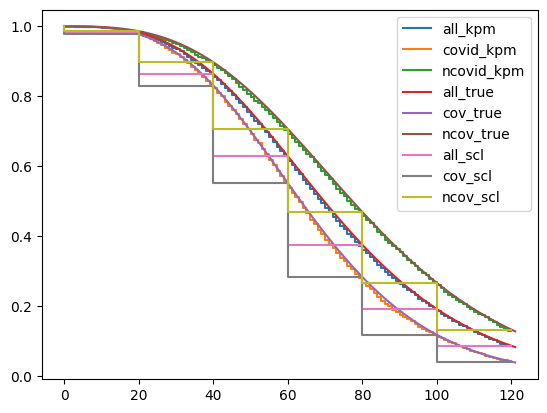

In [75]:
ut.quick_kpm_true(x_mat, status, t_event, true, true_scale)

Similarily the test set evaluation is completed below.

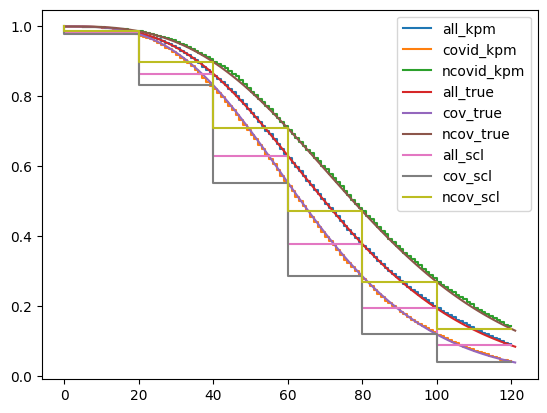

In [76]:
# test comparison
ut.quick_kpm_true(t_x_mat, t_status, t_t_event, t_true, t_true_scale)

Finally the comparison of the scaled times and the true scaled times are completed below. Demonstrating that scaling the event times does not disrupt the estimator or properties of the sv curve.

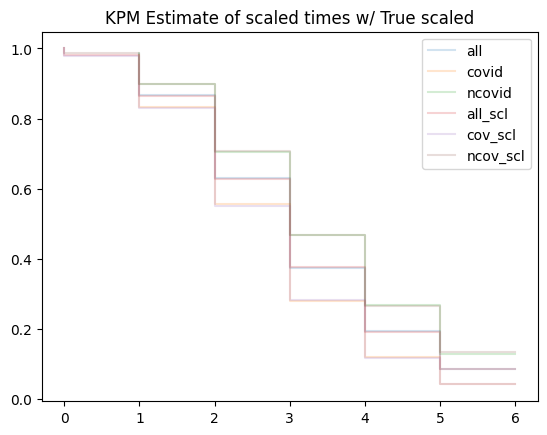

In [77]:
ut.quick_kpm_true_scale(x_mat, status, t_event, true_scale, time_scale)

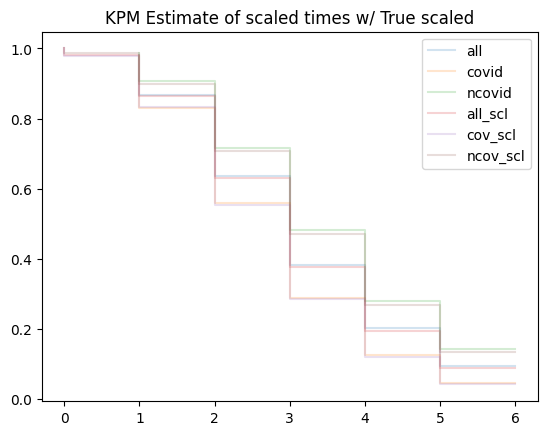

In [78]:
# test
ut.quick_kpm_true_scale(t_x_mat, t_status, t_t_event, t_true_scale, time_scale)

The proposed work is focused on evaluating a main variable ("covid") and this corresponding simulation follows this example w/ the first covariate being a binary variable representing covid status. 

Simple frequencies of the distributions of covid status and corresponding event status are shown below.

In [79]:
mc_mask = (x_mat[:,0] == 1)
train_dict = {
    "N":status.shape,
    "minor class cases" :status[mc_mask].shape[0],
    "minor class events": status[mc_mask].sum(),
    "minor class ev prop": status[mc_mask].sum()/status[mc_mask].shape[0],
    "major class cases":status[~mc_mask].shape[0],
    "major class events" : status[~mc_mask].sum(),
    "major class ev prop": status[~mc_mask].sum()/status[~mc_mask].shape[0]
}

mc_mask = (t_x_mat[:,0] == 1)
test_dict = {
    "N":status.shape,
    "minor class cases" :t_status[mc_mask].shape[0],
    "minor class events": t_status[mc_mask].sum(),
    "minor class ev prop": t_status[mc_mask].sum()/t_status[mc_mask].shape[0],
    "major class cases":t_status[~mc_mask].shape[0],
    "major class events" : t_status[~mc_mask].sum(),
    "major class ev prop": t_status[~mc_mask].sum()/t_status[~mc_mask].shape[0]
}

# log these
print(train_dict)
print(test_dict)

{'N': (10000,), 'minor class cases': 5046, 'minor class events': 4827.0, 'minor class ev prop': 0.9565992865636147, 'major class cases': 4954, 'major class events': 4315.0, 'major class ev prop': 0.8710133225676221}
{'N': (10000,), 'minor class cases': 5046, 'minor class events': 4820.0, 'minor class ev prop': 0.9552120491478399, 'major class cases': 4954, 'major class events': 4244.0, 'major class ev prop': 0.8566814695195801}


# Surv Bart Model

The Surv Bart model is self contained in the surv_bart.py script and access to the prior/model/posteriro fx are accessible as bmb.fx.

The first step is to complete simple transformation of the event_time/status datasets to achieve a long-form sv dataset that can be passed to the bart model. 

Steps:
1. get_time_transform - scales the event times to coarsen the data
    - this allows for more efficient computation as the long-form data entered into the model is of a length n*k were k is the number of distinct time points.
2. get_y_sklearn - joins the status and event_times together into a array of tuples that follow the schema for the scikit_survival package.
3. get_case_cohort - used only in the case of class imbalanced cases (<10%). This returned dataset is a case-cohort sample.
    - when prop = 1, it returns an identity matrix with the y_sk, x_mat and weights of 1.
4. surv_pre_train - creates the long-form training matrix. coh_x now contains the extended time in the first column.
5. get_posterior_test - generates a longform test dataset for predictions through the full length of the survival dataset. 
    - Note that in this first case it is generated on the training dataset.


In [84]:
t_event2 = bmb.get_time_transform(t_event, time_scale=time_scale)
y_sk = bmb.get_y_sklearn(status, t_event2)
y_sk_coh, x_sk_coh, w_coh= bmb.get_case_cohort(y_sk, x_mat, prop = 1)
coh_y, coh_x, coh_w, coh_coords = bmb.surv_pre_train(y_sk_coh, x_sk_coh, w_coh)
x_tst, tst_coords = bmb.get_posterior_test(np.unique(y_sk_coh["Survival_in_days"]), x_sk_coh)

Below the bart model is initiated. There are two parameter objects that needs to be created; the model_dict and sampler_dict.
- model_dict 
    1. trees is the number of trees to generate (20-100 seems to be appropriate). Greater number of trees slows down the analyses.
    2. split_rules is a list of split rules corresponding to each variable in the covariate matrix. The first split rule should always be ContinuousSplitRule since it corresponds to the time column of the long-form x_mat. OneHotSplitRule is used for categorical and binary data, while Continuous should be used for all other variables.
    3. Split prior is a new feature I am working out. It provides the probability of the feature to be selected for a tree. By default this probability is plit uniformly across all variables, but intuition suggests that having a greater probability on the time variable allows for fewer trees as the time is always going to be the major predictor we want included. The split_prior component can be removed if unwanted.
- sampler_dict contains parameters specific for the the sampling step of MCMC. These can all be adjusted. Ideally the number of draws and tune steps should be a balance of sufficiency and computational time. The BART algorithm seems to converge to the sampling distribution quickly, so a smaller number of tune and draws could be beneficial for sampling time.

The bart class object is instantiated with the model parameters. Internally is constructs the framework for the bart model that can be used in a fit step completed after it is instantiated.



In [419]:
# intitialize models
model_dict = {"trees": 75,
    "split_rules": [
    "pmb.ContinuousSplitRule()",
    "pmb.OneHotSplitRule",
    "pmb.ContinuousSplitRule()",
    "pmb.ContinuousSplitRule()",
    "pmb.ContinuousSplitRule()",
    "pmb.OneHotSplitRule()",
    "pmb.ContinuousSplitRule()",
    "pmb.ContinuousSplitRule()",
    "pmb.ContinuousSplitRule()",
    "pmb.ContinuousSplitRule()",
    "pmb.ContinuousSplitRule()"
    ],
    "split_prior": [0.9,
                0.002,
                0.002,
                0.002,
                0.002,
                0.002,
                0.002,
                0.002,
                0.002,
                0.002,
                0.002]
}

sampler_dict = {
            "draws": 100,
            "tune": 100,
            "cores": 4,
            "chains": 4,
            "compute_convergence_checks": False
        }

# initialize bart
bart_model = bmb.BartSurvModel(model_config=model_dict, sampler_config=sampler_dict)

Below the model is fit to the data and posterior predictions of the "mu" parameter (this is our probability risk of event occuring at time) is drawn for each obs at each time point. 

When the model is fit in the same instance that posterior predictions are made we can use the class method sample_posterior_predictive. 

When a trained model is loaded from a prior instance the bart_predict function is used. This comes from an instability of saving the model object internal to the pymc-bart implementation.

The class method save will save both the trace of the trained model (idata) and the trained tree structure. In the survival setting only the tree structure is required for future predictions.

The functions get_prob and get_survival return the predicted risk probabilites and computed survival estimates for each observations for each of the time points. 
- The returned estimates are point-estimates for each patient and stratified credible intervals and point estimates can be drawn from the predictions. These functions will be adjusted to return the raw draws from posterior to compute quantile estimates as well in the future. 

In [420]:
# fit model
bart_model.fit(coh_y, coh_x, coh_w, coh_coords)
# sample posterior
post = bart_model.sample_posterior_predictive(x_tst, tst_coords, extend_idata=True)
# get posterior data
prob = bmb.get_prob(post)
sv = bmb.get_survival(post)
# save idata and tree
bart_model.save(idata_name="test_idata1.pkl", all_tree_name="test_tree1.pkl")

Only 100 samples in chain.
Multiprocess sampling (4 chains in 4 jobs)
PGBART: [f]


Sampling 4 chains for 100 tune and 100 draw iterations (400 + 400 draws total) took 139 seconds.
Sampling: [f]


A Variable importance can be computed from the trained model. The pymc bart package provides an algortihm that computes additives importance of ranked variable as shown in the blocked out code below. This methods takes time to complete and does not provide a large benefit in comparision to the more naive measure of variable importance as shown in the second code block below.

In [418]:
# not needed, used simple var-importance
# pmb.plot_variable_importance(
#     idata=bart_model.idata,
#     bartrv=bart_model.model.f,
#     X=x_tst,
#     samples=100
# )

Naive variable importances shows variable 0 is the most important (the time), followed by several other variables that are included in the data generating process.

The value associated with each variable is the mean inclusion frequency over all of the draws. Unfortunately, this method is not quantitatively robust and the values provide no quantitative purpose beyond relative rank in assessment in the trained model. 

It is useful as a overview of importance similar to variable importance measures returned from Random Forest methods and can direct the follow-up with the Marginal Dependence Evaluation.

In [421]:
# naive variable importance
vars_tree = bart_model.idata.sample_stats.variable_inclusion.values.reshape(400,-1)
vmean = vars_tree.mean(0)
var_dict = dict(zip(np.argsort(-vmean), -np.sort(-vmean)))
var_dict
# save this

{0: 6.135,
 3: 2.5275,
 5: 1.3175,
 1: 1.1525,
 4: 0.9025,
 7: 0.6925,
 10: 0.57,
 2: 0.545,
 8: 0.5075,
 9: 0.465,
 6: 0.375}

# Cox Model

Train a cox model for comparison purposes.

While the exp(coef) returned do not have associated confidence intervals, the point estimate can be used as an approximate comparison of variable importance between cox and bart models.

In [422]:
# cox model
cph_coef, cph_sv, cph_chz = ut.get_cph(y_sk, x_mat, x_mat)

In [3]:
cph_coef

NameError: name 'cph_coef' is not defined

# Model Evaluations

Compare the estimated survival curves of the two models to the kpm estimator. 

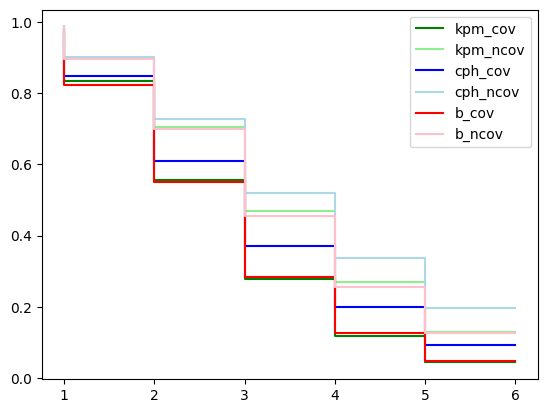

In [423]:
ut.quick_kpm_plot(y_sk, msk=x_mat[:,0]==1, cph_sv=cph_sv, sv=sv)

Get evaluations metrics including the cindex and brier score.

In [425]:
bart_met = ut.get_sv_metrics(sv, prob, y_sk_coh)
cph_met = ut.get_sv_metrics(cph_sv, cph_chz, y_sk)

# log these
print(bart_met)
print(cph_met)

{'cindex': [(0.7090139130090773, 28818559, 11827405, 24, 922350), (0.7096627839382327, 28844944, 11801042, 2, 922350), (0.7098165752546106, 28851195, 11794791, 2, 922350), (0.7097292111585527, 28847643, 11798341, 4, 922350), (0.7097090000617035, 28846823, 11799164, 1, 922350), (0.7096501996703832, 28844432, 11801553, 3, 922350)], 'bs': (array([1., 2., 3., 4., 5.]), array([0.01595338, 0.10757007, 0.19939028, 0.18714505, 0.12423861])), 'ibs': 0.14105035107729003}
{'cindex': [(0.7089685825818774, 28816715, 11829246, 27, 922350), (0.7089685456778662, 28816726, 11829260, 2, 922350), (0.7089685333765291, 28816726, 11829261, 1, 922350), (0.7089685210751919, 28816726, 11829262, 0, 922350), (0.7089685210751919, 28816726, 11829262, 0, 922350), (0.7089685210751919, 28816726, 11829262, 0, 922350)], 'bs': (array([1., 2., 3., 4., 5.]), array([0.01591002, 0.10865201, 0.20333169, 0.19426024, 0.13045325])), 'ibs': 0.14485639274431894}


# Test

To preform out of sample evaluations use the generated test dataset. 

The same data preparations can be used as above.

The bart_model.sample_posterior_predictive can be used to generate predicitons if the testing is be completed in the same instance of the model.fit run. 

In [426]:
# Test
t_t_event2 = bmb.get_time_transform(t_t_event, time_scale=time_scale)
t_y_sk = bmb.get_y_sklearn(t_status, t_t_event2)
t_y_sk_coh, t_x_sk_coh, t_w_coh= bmb.get_case_cohort(t_y_sk, t_x_mat, 1)
t_x_tst, t_tst_coords = bmb.get_posterior_test(np.unique(t_y_sk_coh["Survival_in_days"]), t_x_sk_coh)

t_post = bart_model.sample_posterior_predictive(t_x_tst, t_tst_coords, extend_idata=False)
t_prob = bmb.get_prob(t_post)
t_sv = bmb.get_survival(t_post)

# cox
t_cph_coef, t_cph_sv, t_cph_chz = ut.get_cph(y_sk, x_mat, t_x_mat)


Sampling: [f]


Test dataset evaluation metrics.

{'cindex': [(0.7088013459094045, 28902493, 11874078, 22, 1014624), (0.709426888607393, 28928008, 11848578, 7, 1014624), (0.7096790185487052, 28938291, 11838299, 3, 1014624), (0.7096566282523898, 28937378, 11839212, 3, 1014624), (0.7095613652665881, 28933495, 11843098, 0, 1014624), (0.7094130816667298, 28927446, 11849142, 5, 1014624)], 'bs': (array([1., 2., 3., 4., 5.]), array([0.01680087, 0.10708427, 0.19717365, 0.18867377, 0.12936542])), 'ibs': 0.14150370737274887}
{'cindex': [(0.7101023986972134, 28955541, 11821021, 31, 1014624), (0.7101023373875301, 28955553, 11821038, 2, 1014624), (0.7101023373875301, 28955554, 11821039, 0, 1014624), (0.7101023373875301, 28955554, 11821039, 0, 1014624), (0.7101023373875301, 28955554, 11821039, 0, 1014624), (0.7101023373875301, 28955554, 11821039, 0, 1014624)], 'bs': (array([1., 2., 3., 4., 5.]), array([0.01682422, 0.10777911, 0.20019806, 0.19405063, 0.13387362])), 'ibs': 0.1443441800546639}


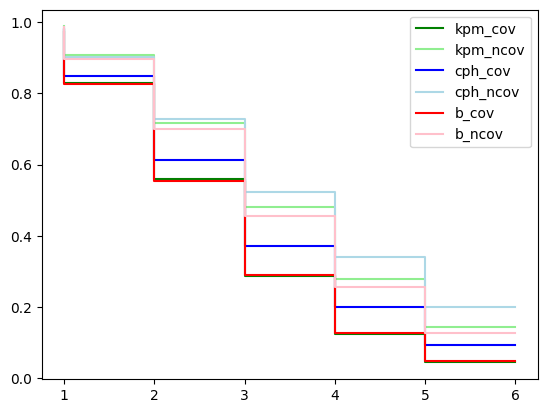

In [427]:
ut.quick_kpm_plot(t_y_sk, t_x_mat[:,0]==1, t_cph_sv, t_sv)
# save this
t_bart_met = ut.get_sv_metrics(t_sv, t_prob, t_y_sk_coh, y_sk_coh)
t_cph_met = ut.get_sv_metrics(t_cph_sv, t_cph_chz, t_y_sk, y_sk)

print(t_bart_met)
print(t_cph_met)

# True Evaluation 

If working with the simulated data, a evaluation can be completed with the true sv/hz estimates. The primary values estimated include rmse and bias.

In [428]:
tmp_times = [0,1,2,3,4,5]
b_true_eval = ut.get_true_rmse_bias(
    true_scale["sv_true"][:,1:], 
    sv,
    tmp_times
    )

cph_true_eval = ut.get_true_rmse_bias(
    true_scale["sv_true"][:,1:], 
    cph_sv,
    tmp_times
    )


t_b_true_eval = ut.get_true_rmse_bias(
    t_true_scale["sv_true"][:,1:], 
    t_sv,
    tmp_times
    )

t_cph_true_eval = ut.get_true_rmse_bias(
    t_true_scale["sv_true"][:,1:], 
    t_cph_sv,
    tmp_times
    )

print(b_true_eval)
print(cph_true_eval)
print(t_b_true_eval)
print(t_cph_true_eval)

{'rmse': array([0.0061, 0.0127, 0.027 , 0.0307, 0.0243, 0.0189]), 'bias': array([0.0037, 0.0039, 0.0056, 0.0064, 0.0013, 0.001 ]), 'time_col': [0, 1, 2, 3, 4, 5]}
{'rmse': array([0.0046, 0.0289, 0.0665, 0.0847, 0.0828, 0.065 ]), 'bias': array([-0.0018, -0.0104, -0.0402, -0.0696, -0.076 , -0.0577]), 'time_col': [0, 1, 2, 3, 4, 5]}
{'rmse': array([0.0056, 0.0116, 0.0266, 0.0308, 0.0257, 0.0201]), 'bias': array([0.0033, 0.0028, 0.0034, 0.0056, 0.0019, 0.0008]), 'time_col': [0, 1, 2, 3, 4, 5]}
{'rmse': array([0.0046, 0.0289, 0.0663, 0.0844, 0.0827, 0.0651]), 'bias': array([-0.0018, -0.0103, -0.0397, -0.0691, -0.0758, -0.0578]), 'time_col': [0, 1, 2, 3, 4, 5]}


A sample comparison of predictions from the different models in comparison to the true sv can also demonstrated through sv plots.

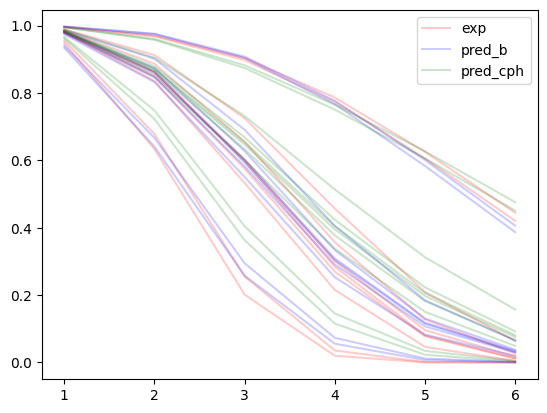

In [429]:
tmp_times = [1,2,3,4,5,6]

for i in np.arange(0,10):
    if i == 0:
        plt.plot(tmp_times, t_true_scale["sv_true"][i,1:], color= "red", alpha= 0.2, label="exp")
        plt.plot(tmp_times, t_sv[i,:], color= "blue", alpha= 0.2, label="pred_b")
        plt.plot(tmp_times, t_cph_sv[i,:], color= "green", alpha= 0.2, label = "pred_cph")
    else:
        plt.plot(tmp_times, t_true_scale["sv_true"][i,1:], color= "red", alpha= 0.2)
        plt.plot(tmp_times, t_sv[i,:], color= "blue", alpha= 0.2)
        plt.plot(tmp_times, t_cph_sv[i,:], color= "green", alpha= 0.2)

plt.legend()
# t_true_scale
# t_sv[0:100]

The stratified estimates by the main variable can be plotted to compare how well the model does at computing the sub-group sv means. 

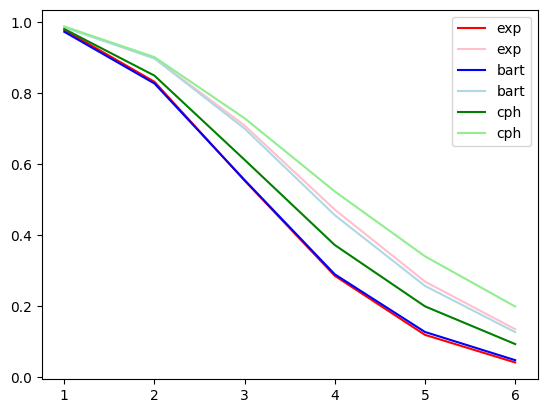

In [430]:
msk = t_x_mat[:,0] == 1

m1 = t_true_scale["sv_true"][msk,1:].mean(axis=0)
m1_ = t_true_scale["sv_true"][~msk,1:].mean(axis=0)
m2 = t_sv[msk,:].mean(axis=0)
m2_ = t_sv[~msk,:].mean(axis=0)
m3 = t_cph_sv[msk,:].mean(axis=0)
m3_ = t_cph_sv[~msk,:].mean(axis=0)


tmp_times = [1,2,3,4,5,6]
plt.plot(tmp_times, m1, color = "red", label = "exp")
plt.plot(tmp_times, m1_, color= "pink", label = "exp")
plt.plot(tmp_times, m2, color = "blue", label="bart")
plt.plot(tmp_times, m2_, color = "lightblue", label= "bart")
plt.plot(tmp_times, m3, color = "green", label= "cph")
plt.plot(tmp_times, m3_, color = "lightgreen", label = "cph")

plt.legend()


# PDP Evaluations

PDP evaluations allow estimations of marginal effects of a variable. This is part of the primary outcome of the proposed study.

In the databricks workflows this process will be seperated from the model training, to allow for specific pdps to tested. 

Doing this in a new compute instance requires predictions to be drawn with a different method.

1. Instantiate a new surv_bart model and load the saved trace and tree structure.
2. Collect the training data loaded with the model. 
3. get_pdp is a function that generates a pdp testing dataset. One or two variables can be selected for the pdp and a subsample of the training data can be used if the data is large.
4. use get_posterior_test to create the long-form dataset for predictions.

In [431]:
bart_m2 = bmb.BartSurvModel(model_config=model_dict).load("test_idata1.pkl", "test_tree1.pkl")
x2 = bart_m2.X[bart_m2.X[:,0]==1][:,1:]
pdp_sk, pdp_idx = bmb.get_pdp(x2, var_col = [0], values = [[0,1]], sample_n=1000)
pdp_x, pdp_coords = bmb.get_posterior_test(bart_m2.uniq_times, pdp_sk)

1. bart_predict - returns posterior draws of the risk probability, similar to get_posterior_predictions above
2. get_survival/get_prob to return patientwise point estimates

In [432]:
pdp_post = bart_m2.bart_predict(pdp_x, pdp_coords)
pdp_sv = bmb.get_survival(pdp_post)
pdp_prob = bmb.get_prob(pdp_post)

For comparison agains the true in a simulated scenario the sim_surv function can be used with the same parameters used in the initial instance, except the x_mat dataset is replaced with the pdp_sk dataset.

In [433]:
pdp_scale = ut.sim_surv(pdp_sk, LAMBDA, ALPHA_F, eos, time_scale=time_scale, return_full=False, true_only=True)

Plot the expected (true) vs predicted values for each patient. The will ideally follow the 1:1 axis.

Text(0.5, 0, 'exp')

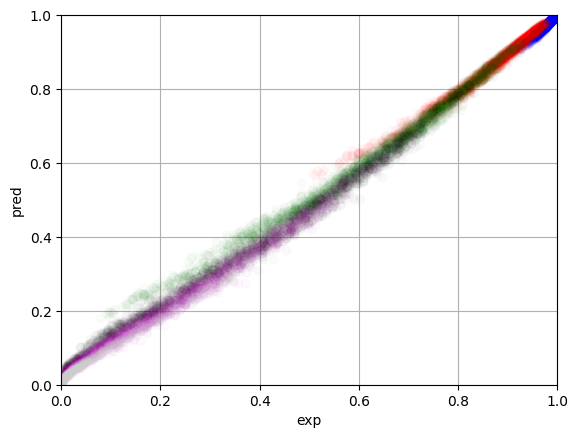

In [434]:
# true plot
plt.plot(pdp_scale["sv_true"][:,1], pdp_sv[:,0], "bo", alpha=0.02)
plt.plot(pdp_scale["sv_true"][:,2], pdp_sv[:,1], "ro", alpha=0.02)
plt.plot(pdp_scale["sv_true"][:,3], pdp_sv[:,2], "go", alpha=0.02)
plt.plot(pdp_scale["sv_true"][:,4], pdp_sv[:,3], "ko", alpha=0.02)
plt.plot(pdp_scale["sv_true"][:,5], pdp_sv[:,4], "mo", alpha=0.02)
plt.plot(pdp_scale["sv_true"][:,6], pdp_sv[:,5], "wo", alpha=0.02)

plt.grid(visible=True)
plt.xlim(0,1)
plt.ylim(0,1)
plt.ylabel("pred")
plt.xlabel("exp")

Plot the pdp comparison of expected pdp and predicted pdp.

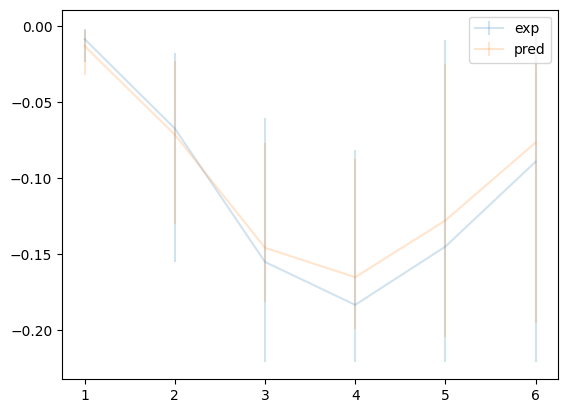

In [435]:
exp0 = pdp_scale["sv_true"][pdp_idx["coord"]==0]
exp1 = pdp_scale["sv_true"][pdp_idx["coord"]==1]
edm = (exp1-exp0).mean(0)
edq = edm - np.quantile((exp1-exp0), [0.025, 0.975], axis=0)

pred0 = pdp_sv[pdp_idx["coord"]==0]
pred1 = pdp_sv[pdp_idx["coord"]==1]
pdm = (pred1-pred0).mean(0)
pdq = pdm - np.quantile((pred1-pred0), [0.025, 0.975], axis=0)

plt.errorbar([1,2,3,4,5,6], y = edm[1:], yerr = np.abs(edq[:,1:]), alpha=0.2, label = "exp")
plt.errorbar([1,2,3,4,5,6], y = pdm, yerr = np.abs(pdq), alpha=0.2, label = "pred")
plt.legend()

Hazard ratios/Risk ratios can also be computed from the pdp predictions using the risk probabilities.

In [416]:
# hr
hr_true = (pdp_scale["hz_true"][pdp_idx["coord"]==1]/pdp_scale["hz_true"][pdp_idx["coord"]==0])
hr_true_m = hr_true.mean(0)
hr_true_q = np.quantile(hr_true, [0.025, 0.975], 0)

rr_pred = (pdp_prob[pdp_idx["coord"]==1]/pdp_prob[pdp_idx["coord"]==0])
rr_pred_m = rr_pred.mean(0)
rr_pred_q = np.quantile(rr_pred, [0.025,0.975],0)

/tmp/ipykernel_408/2742410664.py:2: RuntimeWarning: invalid value encountered in divide
  hr_true = (pdp_scale["hz_true"][pdp_idx["coord"]==1]/pdp_scale["hz_true"][pdp_idx["coord"]==0])


There may be some notable differences in this ratio since the true would be more equivalent to a HR and the expected is a Risk Ratio and some difference exist between these measures.

In [417]:
print(hr_true_m)
print(hr_true_q)
print(hr_true_m[1:].mean())
print(rr_pred_m)
print(rr_pred_q)
print(rr_pred_m.mean())


[       nan 1.65804555 1.77704922 1.85058306 1.9045942  1.94757171
 1.98340582]
[[       nan 1.59215249 1.70642679 1.77703829 1.82890294 1.87017247
  1.90458248]
 [       nan 1.72498767 1.84879601 1.92529872 1.9814905  2.0262032
  2.06348407]]
1.8535415930334926
[1.81038118 1.70942741 1.54415845 1.41123262 1.29322765 1.22602439]
[[1.62180792 1.47192778 1.31257077 1.20019899 1.13529517 1.09919127]
 [1.99079486 1.93095504 1.80035291 1.66229619 1.49587339 1.40082902]]
1.4990752834434942


## General PDP

Outside of the simulation scenario, each variable can be evaluated with a pdp to derive estimated marginal effect of the variable.

The magnitude of estimated effects should follow the rank of the variable importance given above.

NOTE: Sometimes we refer to the variable 0 as the time and othertimes we refer to it as the first variable of the covariate matrix. When generating the PDPs the first variables of covariate matrix is index 0 and once the long form predicton matrix is generated the index 0 variable is now time, moving the first variable to index 1.

[1.97777259 1.78676302 1.58500142 1.4440936  1.32625667 1.23981305]
[[1.77375128 1.5416071  1.32884296 1.21068239 1.13672413 1.09220258]
 [2.16763621 2.02841288 1.87252419 1.73900129 1.57825623 1.44354393]]
1.5599500584523713
[1.34730174 1.80489579]


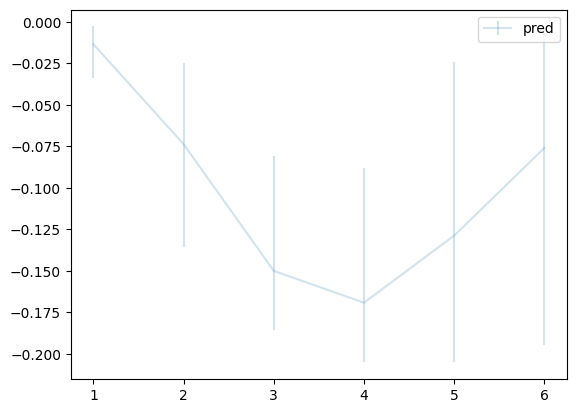

In [440]:
var_pdp = 0
v2q = np.quantile(x2[:,var_pdp], [0.25,0.75])
pdp_sk, pdp_idx = bmb.get_pdp(x2, var_col = [var_pdp], values = [v2q], sample_n=1000)
pdp_x, pdp_coords = bmb.get_posterior_test(bart_m2.uniq_times, pdp_sk)
pdp_post = bart_m2.bart_predict(pdp_x, pdp_coords)
pdp_sv = bmb.get_survival(pdp_post)
pdp_prob = bmb.get_prob(pdp_post)

pred0 = pdp_sv[pdp_idx["coord"]==0]
pred1 = pdp_sv[pdp_idx["coord"]==1]
pdm = (pred1-pred0).mean(0)
pdq = pdm - np.quantile((pred1-pred0), [0.025, 0.975], axis=0)

plt.errorbar([1,2,3,4,5,6], y = pdm, yerr = np.abs(pdq), alpha=0.2, label = "pred")
plt.legend()

rr_pred = (pdp_prob[pdp_idx["coord"]==1]/pdp_prob[pdp_idx["coord"]==0])
rr_pred_m = rr_pred.mean(0)
rr_pred_q = np.quantile(rr_pred, [0.025,0.975], 0)

print(rr_pred_m)
print(rr_pred_q)
print(rr_pred_m.mean())
print(rr_pred_q.mean(1))

[0.95780473 0.9845575  0.99049624 1.00063716 1.00009267 1.0019745 ]
[[0.92047999 0.96290587 0.97373575 0.99020525 0.99192296 0.99622763]
 [0.98361393 1.00332592 1.00336973 1.00974614 1.00704678 1.00761962]]
0.9892604653042407
[0.97257958 1.00245368]


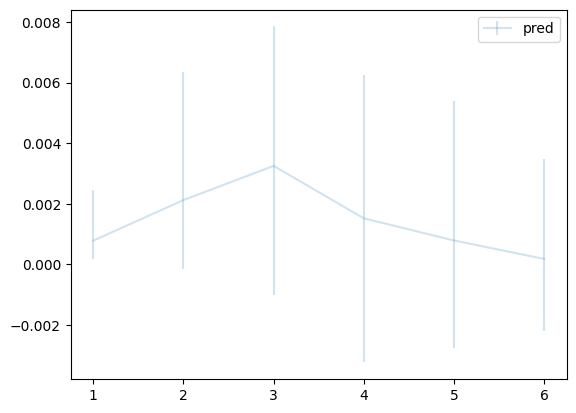

In [441]:
var_pdp = 1
v2q = np.quantile(x2[:,var_pdp], [0.25,0.75])
pdp_sk, pdp_idx = bmb.get_pdp(x2, var_col = [var_pdp], values = [v2q], sample_n=1000)
pdp_x, pdp_coords = bmb.get_posterior_test(bart_m2.uniq_times, pdp_sk)
pdp_post = bart_m2.bart_predict(pdp_x, pdp_coords)
pdp_sv = bmb.get_survival(pdp_post)
pdp_prob = bmb.get_prob(pdp_post)

pred0 = pdp_sv[pdp_idx["coord"]==0]
pred1 = pdp_sv[pdp_idx["coord"]==1]
pdm = (pred1-pred0).mean(0)
pdq = pdm - np.quantile((pred1-pred0), [0.025, 0.975], axis=0)

plt.errorbar([1,2,3,4,5,6], y = pdm, yerr = np.abs(pdq), alpha=0.2, label = "pred")
plt.legend()

rr_pred = (pdp_prob[pdp_idx["coord"]==1]/pdp_prob[pdp_idx["coord"]==0])
rr_pred_m = rr_pred.mean(0)
rr_pred_q = np.quantile(rr_pred, [0.025,0.975], 0)

print(rr_pred_m)
print(rr_pred_q)
print(rr_pred_m.mean())
print(rr_pred_q.mean(1))

[3.18546111 2.64541132 2.05840213 1.75867698 1.53327795 1.36863399]
[[2.79943835 2.18793891 1.66625498 1.42688882 1.27483753 1.17532565]
 [3.63475762 3.16515138 2.52961546 2.1874203  1.88302033 1.63748659]]
2.091643911579293
[1.75511404 2.50624195]


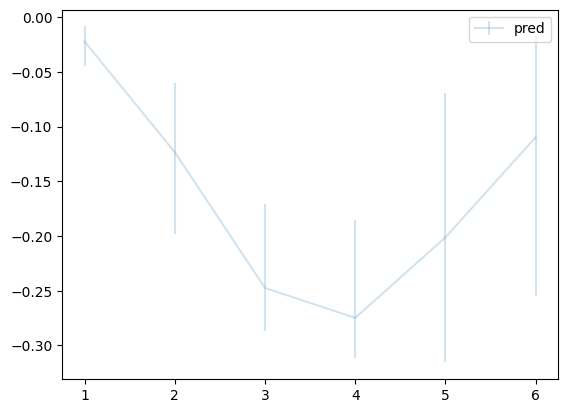

In [442]:
var_pdp = 2
v2q = np.quantile(x2[:,var_pdp], [0.25,0.75])
pdp_sk, pdp_idx = bmb.get_pdp(x2, var_col = [var_pdp], values = [v2q], sample_n=1000)
pdp_x, pdp_coords = bmb.get_posterior_test(bart_m2.uniq_times, pdp_sk)
pdp_post = bart_m2.bart_predict(pdp_x, pdp_coords)
pdp_sv = bmb.get_survival(pdp_post)
pdp_prob = bmb.get_prob(pdp_post)

pred0 = pdp_sv[pdp_idx["coord"]==0]
pred1 = pdp_sv[pdp_idx["coord"]==1]
pdm = (pred1-pred0).mean(0)
pdq = pdm - np.quantile((pred1-pred0), [0.025, 0.975], axis=0)

plt.errorbar([1,2,3,4,5,6], y = pdm, yerr = np.abs(pdq), alpha=0.2, label = "pred")
plt.legend()

rr_pred = (pdp_prob[pdp_idx["coord"]==1]/pdp_prob[pdp_idx["coord"]==0])
rr_pred_m = rr_pred.mean(0)
rr_pred_q = np.quantile(rr_pred, [0.025,0.975], 0)

print(rr_pred_m)
print(rr_pred_q)
print(rr_pred_m.mean())
print(rr_pred_q.mean(1))

[1.34819178 1.29226144 1.234252   1.17448344 1.14586347 1.10994642]
[[1.26182989 1.18255561 1.1192321  1.07263483 1.05224935 1.03579162]
 [1.43941985 1.40298315 1.35395194 1.2918003  1.26638296 1.21079425]]
1.2174997575795132
[1.12071557 1.32755541]


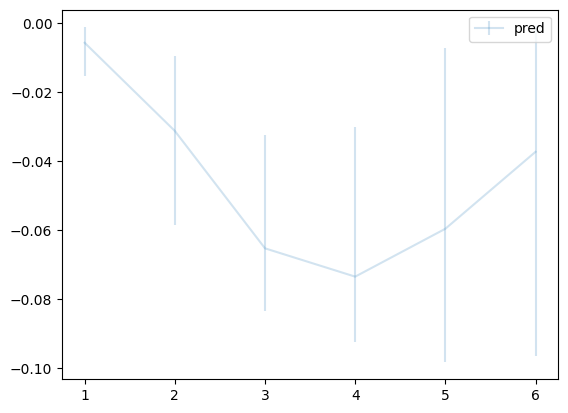

In [443]:
var_pdp = 3
v2q = np.quantile(x2[:,var_pdp], [0.25,0.75])
pdp_sk, pdp_idx = bmb.get_pdp(x2, var_col = [var_pdp], values = [v2q], sample_n=1000)
pdp_x, pdp_coords = bmb.get_posterior_test(bart_m2.uniq_times, pdp_sk)
pdp_post = bart_m2.bart_predict(pdp_x, pdp_coords)
pdp_sv = bmb.get_survival(pdp_post)
pdp_prob = bmb.get_prob(pdp_post)

pred0 = pdp_sv[pdp_idx["coord"]==0]
pred1 = pdp_sv[pdp_idx["coord"]==1]
pdm = (pred1-pred0).mean(0)
pdq = pdm - np.quantile((pred1-pred0), [0.025, 0.975], axis=0)

plt.errorbar([1,2,3,4,5,6], y = pdm, yerr = np.abs(pdq), alpha=0.2, label = "pred")
plt.legend()

rr_pred = (pdp_prob[pdp_idx["coord"]==1]/pdp_prob[pdp_idx["coord"]==0])
rr_pred_m = rr_pred.mean(0)
rr_pred_q = np.quantile(rr_pred, [0.025,0.975], 0)

print(rr_pred_m)
print(rr_pred_q)
print(rr_pred_m.mean())
print(rr_pred_q.mean(1))

[2.03177014 1.81629465 1.64416894 1.44434428 1.33006411 1.26225339]
[[1.79922515 1.54301303 1.35379665 1.20697539 1.13694005 1.10134   ]
 [2.25551735 2.06245351 1.95009666 1.73317397 1.5852465  1.48704108]]
1.5881492523596237
[1.35688171 1.84558818]


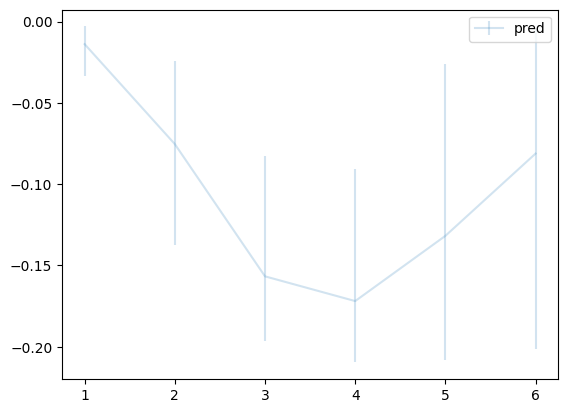

In [444]:
var_pdp = 4
v2q = np.quantile(x2[:,var_pdp], [0.25,0.75])
pdp_sk, pdp_idx = bmb.get_pdp(x2, var_col = [var_pdp], values = [v2q], sample_n=1000)
pdp_x, pdp_coords = bmb.get_posterior_test(bart_m2.uniq_times, pdp_sk)
pdp_post = bart_m2.bart_predict(pdp_x, pdp_coords)
pdp_sv = bmb.get_survival(pdp_post)
pdp_prob = bmb.get_prob(pdp_post)

pred0 = pdp_sv[pdp_idx["coord"]==0]
pred1 = pdp_sv[pdp_idx["coord"]==1]
pdm = (pred1-pred0).mean(0)
pdq = pdm - np.quantile((pred1-pred0), [0.025, 0.975], axis=0)

plt.errorbar([1,2,3,4,5,6], y = pdm, yerr = np.abs(pdq), alpha=0.2, label = "pred")
plt.legend()

rr_pred = (pdp_prob[pdp_idx["coord"]==1]/pdp_prob[pdp_idx["coord"]==0])
rr_pred_m = rr_pred.mean(0)
rr_pred_q = np.quantile(rr_pred, [0.025,0.975], 0)

print(rr_pred_m)
print(rr_pred_q)
print(rr_pred_m.mean())
print(rr_pred_q.mean(1))

[0.99925267 1.01966762 1.0188789  1.01732518 1.01240269 1.01003931]
[[0.9769392  1.00539416 1.00633719 1.00525008 1.00290858 1.00216853]
 [1.02095938 1.0368692  1.033043   1.03152026 1.02408394 1.02039002]]
1.012927727463234
[0.99983296 1.02781097]


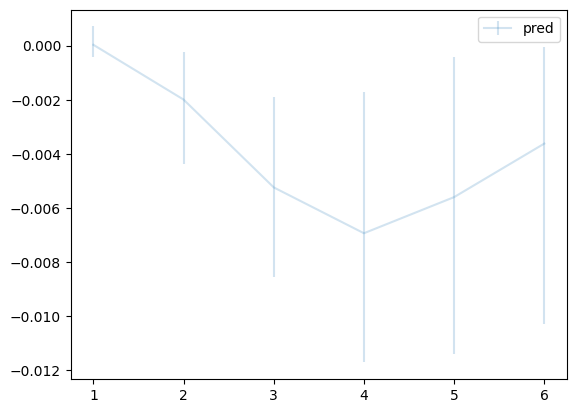

In [445]:
var_pdp = 5
v2q = np.quantile(x2[:,var_pdp], [0.25,0.75])
pdp_sk, pdp_idx = bmb.get_pdp(x2, var_col = [var_pdp], values = [v2q], sample_n=1000)
pdp_x, pdp_coords = bmb.get_posterior_test(bart_m2.uniq_times, pdp_sk)
pdp_post = bart_m2.bart_predict(pdp_x, pdp_coords)
pdp_sv = bmb.get_survival(pdp_post)
pdp_prob = bmb.get_prob(pdp_post)

pred0 = pdp_sv[pdp_idx["coord"]==0]
pred1 = pdp_sv[pdp_idx["coord"]==1]
pdm = (pred1-pred0).mean(0)
pdq = pdm - np.quantile((pred1-pred0), [0.025, 0.975], axis=0)

plt.errorbar([1,2,3,4,5,6], y = pdm, yerr = np.abs(pdq), alpha=0.2, label = "pred")
plt.legend()

rr_pred = (pdp_prob[pdp_idx["coord"]==1]/pdp_prob[pdp_idx["coord"]==0])
rr_pred_m = rr_pred.mean(0)
rr_pred_q = np.quantile(rr_pred, [0.025,0.975], 0)

print(rr_pred_m)
print(rr_pred_q)
print(rr_pred_m.mean())
print(rr_pred_q.mean(1))

[1.0002045  0.99101168 0.99520803 1.00083946 1.00255718 0.99963745]
[[0.96642505 0.96818827 0.97600939 0.98781867 0.9930776  0.9912642 ]
 [1.03202804 1.00978199 1.00960479 1.01195838 1.01148112 1.00624563]]
0.9982430498217457
[0.98046386 1.01351666]


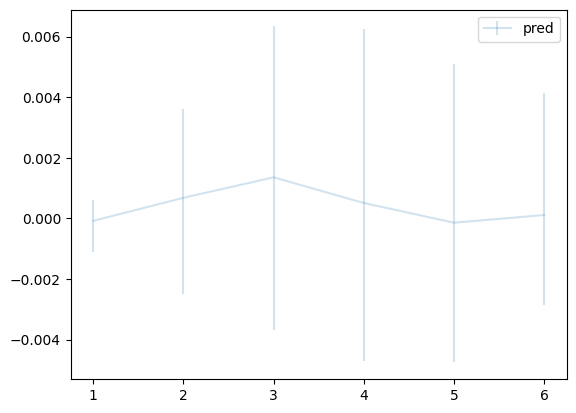

In [446]:
var_pdp = 6
v2q = np.quantile(x2[:,var_pdp], [0.25,0.75])
pdp_sk, pdp_idx = bmb.get_pdp(x2, var_col = [var_pdp], values = [v2q], sample_n=1000)
pdp_x, pdp_coords = bmb.get_posterior_test(bart_m2.uniq_times, pdp_sk)
pdp_post = bart_m2.bart_predict(pdp_x, pdp_coords)
pdp_sv = bmb.get_survival(pdp_post)
pdp_prob = bmb.get_prob(pdp_post)

pred0 = pdp_sv[pdp_idx["coord"]==0]
pred1 = pdp_sv[pdp_idx["coord"]==1]
pdm = (pred1-pred0).mean(0)
pdq = pdm - np.quantile((pred1-pred0), [0.025, 0.975], axis=0)

plt.errorbar([1,2,3,4,5,6], y = pdm, yerr = np.abs(pdq), alpha=0.2, label = "pred")
plt.legend()

rr_pred = (pdp_prob[pdp_idx["coord"]==1]/pdp_prob[pdp_idx["coord"]==0])
rr_pred_m = rr_pred.mean(0)
rr_pred_q = np.quantile(rr_pred, [0.025,0.975], 0)

print(rr_pred_m)
print(rr_pred_q)
print(rr_pred_m.mean())
print(rr_pred_q.mean(1))

[0.98389075 0.9990701  1.00080019 0.99355398 0.99206992 0.99298628]
[[0.96198257 0.98484189 0.99155635 0.98524352 0.98306898 0.98492808]
 [1.00431923 1.01403754 1.01119576 1.00027091 0.99800627 0.99800576]]
0.9937285361145319
[0.9819369  1.00430591]


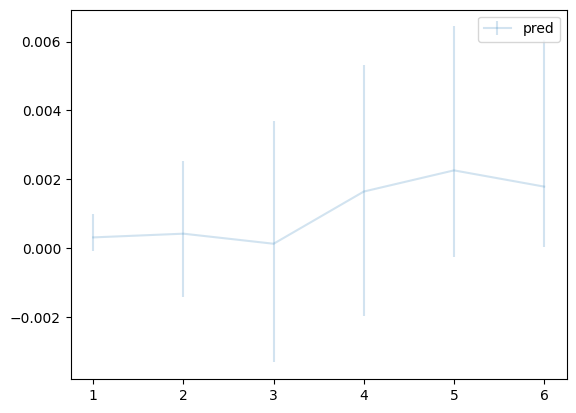

In [447]:
var_pdp = 7
v2q = np.quantile(x2[:,var_pdp], [0.25,0.75])
pdp_sk, pdp_idx = bmb.get_pdp(x2, var_col = [var_pdp], values = [v2q], sample_n=1000)
pdp_x, pdp_coords = bmb.get_posterior_test(bart_m2.uniq_times, pdp_sk)
pdp_post = bart_m2.bart_predict(pdp_x, pdp_coords)
pdp_sv = bmb.get_survival(pdp_post)
pdp_prob = bmb.get_prob(pdp_post)

pred0 = pdp_sv[pdp_idx["coord"]==0]
pred1 = pdp_sv[pdp_idx["coord"]==1]
pdm = (pred1-pred0).mean(0)
pdq = pdm - np.quantile((pred1-pred0), [0.025, 0.975], axis=0)

plt.errorbar([1,2,3,4,5,6], y = pdm, yerr = np.abs(pdq), alpha=0.2, label = "pred")
plt.legend()

rr_pred = (pdp_prob[pdp_idx["coord"]==1]/pdp_prob[pdp_idx["coord"]==0])
rr_pred_m = rr_pred.mean(0)
rr_pred_q = np.quantile(rr_pred, [0.025,0.975], 0)

print(rr_pred_m)
print(rr_pred_q)
print(rr_pred_m.mean())
print(rr_pred_q.mean(1))

[1.03198268 1.01761666 0.99708364 0.99831057 0.99275968 0.99800654]
[[0.99789302 0.99877844 0.98551364 0.99034928 0.98538516 0.99294028]
 [1.07644529 1.04231637 1.01183419 1.00881416 0.99952176 1.00433274]]
1.005959960887235
[0.99180997 1.02387742]


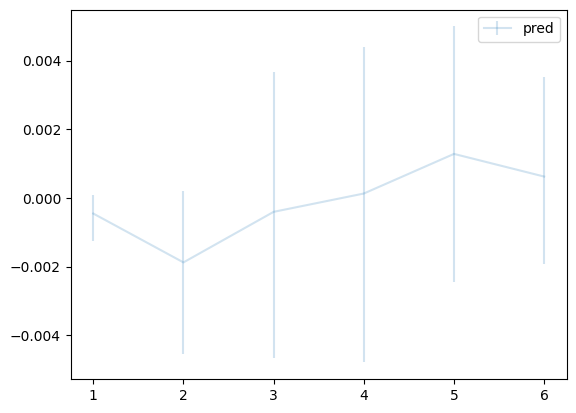

In [448]:
var_pdp = 8
v2q = np.quantile(x2[:,var_pdp], [0.25,0.75])
pdp_sk, pdp_idx = bmb.get_pdp(x2, var_col = [var_pdp], values = [v2q], sample_n=1000)
pdp_x, pdp_coords = bmb.get_posterior_test(bart_m2.uniq_times, pdp_sk)
pdp_post = bart_m2.bart_predict(pdp_x, pdp_coords)
pdp_sv = bmb.get_survival(pdp_post)
pdp_prob = bmb.get_prob(pdp_post)

pred0 = pdp_sv[pdp_idx["coord"]==0]
pred1 = pdp_sv[pdp_idx["coord"]==1]
pdm = (pred1-pred0).mean(0)
pdq = pdm - np.quantile((pred1-pred0), [0.025, 0.975], axis=0)

plt.errorbar([1,2,3,4,5,6], y = pdm, yerr = np.abs(pdq), alpha=0.2, label = "pred")
plt.legend()

rr_pred = (pdp_prob[pdp_idx["coord"]==1]/pdp_prob[pdp_idx["coord"]==0])
rr_pred_m = rr_pred.mean(0)
rr_pred_q = np.quantile(rr_pred, [0.025,0.975], 0)

print(rr_pred_m)
print(rr_pred_q)
print(rr_pred_m.mean())
print(rr_pred_q.mean(1))

[0.97943909 0.9993774  0.99812575 0.99493436 0.99611947 0.99723177]
[[0.94828301 0.97931953 0.98359881 0.98406867 0.9873     0.99016804]
 [1.01410719 1.02424679 1.01663716 1.00679917 1.00522455 1.00473306]]
0.9942046397626587
[0.97878968 1.01195799]


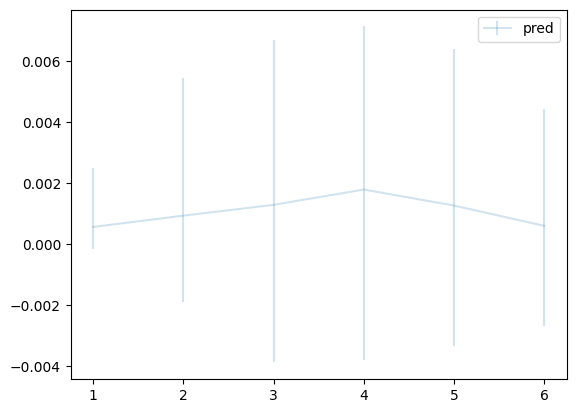

In [449]:
var_pdp = 9
v2q = np.quantile(x2[:,var_pdp], [0.25,0.75])
pdp_sk, pdp_idx = bmb.get_pdp(x2, var_col = [var_pdp], values = [v2q], sample_n=1000)
pdp_x, pdp_coords = bmb.get_posterior_test(bart_m2.uniq_times, pdp_sk)
pdp_post = bart_m2.bart_predict(pdp_x, pdp_coords)
pdp_sv = bmb.get_survival(pdp_post)
pdp_prob = bmb.get_prob(pdp_post)

pred0 = pdp_sv[pdp_idx["coord"]==0]
pred1 = pdp_sv[pdp_idx["coord"]==1]
pdm = (pred1-pred0).mean(0)
pdq = pdm - np.quantile((pred1-pred0), [0.025, 0.975], axis=0)

plt.errorbar([1,2,3,4,5,6], y = pdm, yerr = np.abs(pdq), alpha=0.2, label = "pred")
plt.legend()

rr_pred = (pdp_prob[pdp_idx["coord"]==1]/pdp_prob[pdp_idx["coord"]==0])
rr_pred_m = rr_pred.mean(0)
rr_pred_q = np.quantile(rr_pred, [0.025,0.975], 0)

print(rr_pred_m)
print(rr_pred_q)
print(rr_pred_m.mean())
print(rr_pred_q.mean(1))

Comparisons of the estimated Risk Ratio can be compared to CPH HR that are listed below.

In [450]:
cph_coef

{'exp coef': array([1.57863117, 1.00336181, 1.57030346, 1.58523306, 1.58156738,
        1.01270981, 0.9868341 , 0.97634183, 1.00121709, 0.97464106])}